# Телеком — Определение неэффективных операторов

* [Презентация](https://disk.yandex.com/d/sBeBcRbHzcHdEg)
* [Дашборд](https://public.tableau.com/app/profile/alena.kotovich/viz/telecom_16256037181850/Dashboard1)

## Описание проекта

Помогите «Нупозвони» найти самых неэффективных операторов. Признаки низкой эффективности:

- много пропущенных входящих вызовов,
- долгое ожидания ответа при входящих внешних вызовах,
- мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.


## Описание данных

Датасеты описывают использование услуг «Нупозвони» — провайдера виртуальный телефонии. Его клиенты — колл-центры, которые: 

- распределяют входящие вызовы на операторов,
- совершают исходящие вызовы силами операторов.

Также операторы могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии.

Колонки в `telecom_dataset.csv.zip`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента(true - внутренний, false - внешний)
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

Колонки в `telecom_clients.csv`:

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиентв в сервисе

##  План выполнения

1. [Выгрузка данных и их анализ](#step_1);
2. Предобработка данных:
    - [преобразовать к нужным типам данные](#step_2);
    - [найти дубликаты и проанализировать их](#step_3);
    - [обработать пропуски](#step_4);
    - [проведение дополнительных расчётов](#step_5);
3. Исследовательский анализ данных:
    - [анализ направленности вызовов колл-центров](#step_6);
    - [анализ количества звонков](#step_7);
    - [анализ длительности звонков](#step_8);
    - [анализ длительности ожидания](#step_9);
    - [анализ пропущенных звонков](#step_10);
    - [анализ звонков по дням недели](#step_11);
    - [анализ внутренних и внешних вызовов](#step_12);
    - [сводная таблица](#step_13);   
4. Создание портрета неэффективного оператора:
    - [для обзванивающих колл-центров](#step_14);
    - [для колл-центров поддержки](#step_15);
    - [анализ вызовов без operator_id](#step_16); 
5. Проверка гипотез:
    - [время ожидания ответа зависит тарифного плана](#step_17);
    - [длительность звонков зависит от того внутренний он или внешний](#step_18);
6. [Выводы и рекомендации](#step_19);
7. Презентация;
8. Дашборд с информацией:
    - диаграмма количества вызовов по дням;
    - круговая диаграмма, отображающая соотношение кол-ва входящих и исходящих вызовов;
    - сожержит фильтр дашборда по типу вызова (внешний или внутренний)

### Выгрузка данных

<a id='step_1'></a>

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import normaltest
import scipy.stats as stats
from scipy.stats import f_oneway
import datetime

In [3]:
# выгрузка данных
try:
    data_calls = pd.read_csv('')
    data_clients = pd.read_csv('')
except:   
    data_calls = pd.read_csv('')
    data_clients = pd.read_csv('')

In [4]:
data_calls.head(15)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


In [5]:
print('Пропуски в данных')
data_calls.isna().sum()

Пропуски в данных


user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [6]:
print('Количество клиентов на начальном этапе',data_calls['user_id'].nunique())

Количество клиентов на начальном этапе 307


In [7]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [8]:
data_clients.head(15)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
5,167764,A,2019-09-30
6,167050,A,2019-08-29
7,168252,A,2019-10-17
8,168495,A,2019-10-28
9,167879,A,2019-10-03


**Выводы по анализу входных данных**

В датасете data_calls есть пропуски в столбцах internal и operator_id. Далее они будут изучены и обработаны. Дату можно привести к более удобному виду, оставив только число. operator_id можно привести к типу int. internal привести к типу bool. 

В датасете data_clients нет пропусков. Дату приведём к нужному типу данных.

### Предобработка данных

**Преобразование к нужным типам данные**<a id='step_2'></a>

In [9]:
data_calls['operator_id'] = pd.to_numeric(data_calls['operator_id'],errors='coerce')

In [10]:
data_calls['date']  = data_calls['date'].astype('datetime64[D]')
data_clients['date_start']  = data_clients['date_start'].astype('datetime64[D]')

In [11]:
data_calls['internal']  = data_calls['internal'].astype('bool')

In [12]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null datetime64[ns]
direction              53902 non-null object
internal               53902 non-null bool
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.0+ MB


In [13]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


**Поиск дубликатов**<a id='step_3'></a>

In [14]:
print('Дубликатов в данных о звонках',data_calls.duplicated().sum())
print('Дубликатов в данных о клиентах',data_clients.duplicated().sum())

Дубликатов в данных о звонках 4900
Дубликатов в данных о клиентах 0


In [15]:
print('Процент дубликатов в данных',data_calls.duplicated().sum()/data_calls.shape[0] * 100)

Процент дубликатов в данных 9.090571778412675


In [16]:
data_dubl = data_calls.copy()
data_dubl['dupl'] = data_dubl.duplicated()
data_dubl_grouped = data_dubl.query('dupl == True').groupby('user_id')['calls_count'].count()
data_dubl_grouped.sort_values(ascending=False).head(10)

user_id
168187    238
166658    223
167626    131
167497    124
168361    113
166916    104
168062    101
167150     93
166983     89
166511     88
Name: calls_count, dtype: int64

Дубликатов в данных о звонках 4900. Это 9% от всего количества данных. Болше всего о клиентах с user_id 168187 и 166658. Эти дубликаты можно удалить. Но сообщить об этом тем, от кого поступили данные.  

In [17]:
data_calls = data_calls.drop_duplicates().reset_index(drop = True)

In [18]:
print('Дубликатов в данных о звонках',data_calls.duplicated().sum())

Дубликатов в данных о звонках 0


**Обработка пропусков**<a id='step_4'></a>

In [19]:
data_calls.isna().sum()

user_id                   0
date                      0
direction                 0
internal                  0
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [20]:
data_calls.loc[data_calls['operator_id'].isna()].\
groupby('user_id').count().\
sort_values(by='direction',ascending=False).head()

,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
user_id,,,,,,,,
168252,135,135,135,0,135,135,135,135
166582,111,111,111,0,111,111,111,111
166405,111,111,111,0,111,111,111,111
166782,106,106,106,0,106,106,106,106
166658,103,103,103,0,103,103,103,103


In [21]:
data_calls.loc[(data_calls['operator_id'].isna()&(data_calls['is_missed_call']==True))].\
groupby('user_id').count().\
sort_values(by='direction',ascending=False).head()

,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
user_id,,,,,,,,
166582,111,111,111,0,111,111,111,111
166405,111,111,111,0,111,111,111,111
166658,103,103,103,0,103,103,103,103
166782,90,90,90,0,90,90,90,90
166983,90,90,90,0,90,90,90,90


In [22]:
data_calls_without_op_id = data_calls.loc[data_calls['operator_id'].isna()]

Так как главная цель - определение неэффективных операторов, то строки с пропусками в столбце operator_id можно удалить. И если присмотреться, то можно заметить, что зачастую это пропущенные входящие вызовы. И как видно из таблиц выше, большая часть звонков без идентификатора оператора это пропущенные звонки. Виновника-оператора не найти. 

Данные без operator_id будут сохранены в таблице data_calls_without_op_id.

In [23]:
data_calls.dropna(subset=['operator_id'], inplace = True)
data_calls.isna().sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64

In [24]:
print('Количество клиентов ',data_calls['user_id'].nunique())
print('Количество клиентов ',data_clients['user_id'].nunique())

Количество клиентов  290
Количество клиентов  732


Было 307 клиентов. Стало 290. 

In [25]:
print('Клиенты, у которых нет идентификаторов операторов чаще всего')
data_calls_without_op_id.groupby('user_id')['calls_count'].count().sort_values(ascending=False).head(15)

Клиенты, у которых нет идентификаторов операторов чаще всего


user_id
168252    135
166405    111
166582    111
166782    106
166658    103
166983     90
166916     85
166541     78
167497     77
166708     77
166485     77
168187     75
166503     75
166520     75
167650     74
Name: calls_count, dtype: int64

**Проведение дополнительных расчётов**<a id='step_5'></a>

In [26]:
# день недели
data_calls['weekday'] = data_calls['date'].dt.weekday
# месяц
data_calls['month'] = data_calls['date'].dt.month
# номер недели
data_calls['week_num']  = data_calls['date'].dt.week

In [27]:
# время ожидания 
data_calls['expectation'] = data_calls['total_call_duration'] - data_calls['call_duration']

Дубликатов в данных о звонках 4900. Это 9% от всего количества данных. 
Топ-10 клиентов с дубликатами:

    - 168187    
    - 166658    
    - 167626    
    - 167497    
    - 168361    
    - 166916    
    - 168062    
    - 167150     
    - 166983     
    - 166511     
Дубликаты были удалены.

**Выводы после предобработки данных**

Были исправлены типы данных. там где это требовалось. 

Было обнаружено 9% полных дубликатов среди данных о звонках операторов. Следует сообщить об этом дата инженеру, который предоставил данные. Мы удалили эти дубликаты за ненадобностью. 

В operator_id была найдено 7456 пропусков. Чаще всего это пропущенные звонки - операторы даже не были назначены, либо ещё какие-то сбои в системе. Такие строки были сохранены в одельный датасет и будут проанализированы ниже, чтобы сообщить клиентам о таком недочёте.

Были проведены дополнительные расчёты по определению дня недели, месяца, номера недели и длительности ожидания ответа.

### Исследовательский анализ данных

In [28]:
# Объединим таблицы
data = data_calls.merge(data_clients, left_on=['user_id'], right_on=['user_id'])
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,weekday,month,week_num,expectation,tariff_plan,date_start
0,166377,2019-08-04,out,True,880022.0,True,3,0,5,6,8,31,5,B,2019-08-01
1,166377,2019-08-04,out,True,880020.0,True,1,0,1,6,8,31,1,B,2019-08-01
2,166377,2019-08-04,out,True,880020.0,False,1,10,18,6,8,31,8,B,2019-08-01
3,166377,2019-08-04,out,False,880022.0,True,3,0,25,6,8,31,25,B,2019-08-01
4,166377,2019-08-04,out,False,880020.0,False,2,3,29,6,8,31,26,B,2019-08-01


In [29]:
print('Начальная дата исследования ',data['date'].min())
print('Конечная дата исследования ',data['date'].max())

Начальная дата исследования  2019-08-01 00:00:00
Конечная дата исследования  2019-11-27 00:00:00


Далее я буду использовать следующую терминологию:

Медиана – это уровень показателя, который делит набор данных на две равные половины.

Квартиль - это то, что делит данные на три точки и четыре интервала.

Процентиль -  это определенная часть выборки данных. Например, пятый процентиль охватывает 5% объема выборки.

Среднеквадратичное отклонение - это распространенный показатель рассеяния в статистике.

**Проверим данные на наличие выбросов и отчистим их**

Выбросы являются точками данных, которые лежат вдали от обычного распределения данных.

Для очистки данных воспользуемся границамиравными 5 и 95 процентилям.

 
    
Для отчистки данных от них, мы используем межквартильный диапозон(IQR). Это разница между третьим квартилем и первым квартилем (IQR = Q3 -Q1). Выбросы в этом случае определяются как наблюдения, которые ниже (Q1 - 1,5x IQR) или нижний ус или выше (Q3 + 1,5x IQR) или верхний ус.
    
Этот метод оказлся слишком строгим и данных стало в 8 раз меньше. В функции ниже закоментированы попытки данного метода.    


Так как количество звонков отвеченных и неотвеченных различно, то справделивее будет отчищать от выбросов их отдельно. Анализировать и чистить будем следующие столбцы: calls_count, call_duration, expectation.

In [30]:
def clean_emissions(df, col, query_conditions):
    """Функция для чистки данных от выбросов"""
    # 1 и второй квартиль
    #q_25 = df.query(query_conditions)[col].describe()[4]
    #q_75 = df.query(query_conditions)[col].describe()[6]
    # межвартильный размах
    #q_75_q_25 = q_75 - q_25
    # границы очистки
    #max_range = q_75 + (1.5 * q_75_q_25)
    #min_range = q_25 - (1.5 * q_75_q_25)
    #if max_range > df.query(query_conditions)[col].describe()[7]:
    #    max_range = df.query(query_conditions)[col].describe()[7]
    #else:
    #    max_range = max_range
    #if min_range < df.query(query_conditions)[col].describe()[3]:
    #    min_range = df.query(query_conditions)[col].describe()[3]
    #else:
    #   min_range = min_range  
    
    max_range = df.query(query_conditions)[col].quantile(0.95)
    min_range = df.query(query_conditions)[col].quantile(0.05)    
    df = df.loc[((df[col] <= max_range) & (df[col] >= min_range))]  
    print('Верхняя и нижняя границы чистки данных от выбросов для', col, ":",max_range, min_range)
    return df

In [31]:
print('Количество строк до чистки выбросов',data.shape)

Количество строк до чистки выбросов (41546, 15)


In [32]:
parameter_list = ['calls_count', 'call_duration', 'expectation']
for col in parameter_list:
    data = clean_emissions(data, col, 'is_missed_call == False')
    data = clean_emissions(data, col, 'is_missed_call == True')

Верхняя и нижняя границы чистки данных от выбросов для calls_count : 61.0 1.0
Верхняя и нижняя границы чистки данных от выбросов для calls_count : 40.0 1.0
Верхняя и нижняя границы чистки данных от выбросов для call_duration : 3148.0 14.0
Верхняя и нижняя границы чистки данных от выбросов для call_duration : 520.0999999999999 20.0
Верхняя и нижняя границы чистки данных от выбросов для expectation : 127.0 4.0
Верхняя и нижняя границы чистки данных от выбросов для expectation : 80.14999999999995 4.0


In [33]:
print('Количество строк после чистки выбросов',data.shape)

Количество строк после чистки выбросов (10877, 15)


Уберём данные, которые соответствуют неполным неделям. Так как далее анализ будет проходить по неделям.

In [34]:
data = data.query('(week_num > 33)&(week_num < 48)')

**Анализ направленности работы клиентов**<a id='step_6'></a>


Направленность колл-центров проанализируем по сумме звонков в неделю по всему колл-центру. Если в среднем входящих вызовов больше, то колл-центр относится к поддержке, если наоборот - то к обзванивающему типу.  
    


In [35]:
# Список всех клиентов
user_list = data['user_id'].unique().tolist()
data_grouped_by_user = data.groupby('user_id')

In [36]:
# Разделим клиентов по направленности работы: входящие и исходящие
user_list_in = []
user_list_out = []
data_grouped_by_week = data.groupby('week_num')
for user in user_list:
    count_out = data.query('(direction == "out") & (user_id == @user)').groupby('week_num')['calls_count'].sum().median()
    count_in = data.query('(direction == "in") & (user_id == @user)').groupby('week_num')['calls_count'].sum().median()
    if count_out > count_in:
        user_list_out.append(user)
    else:
        user_list_in.append(user)
print('Количество колл-центров, работающих на исходящие звонки',len(user_list_out))   
print('Количество колл-центров, работающие на входящие звонки',len(user_list_in)) 

Количество колл-центров, работающих на исходящие звонки 86
Количество колл-центров, работающие на входящие звонки 182


Разделим датасет на две части: колл-центры с входящими и исходящими звонками. Далее будем анализировать их отдельно друг от друга.

In [37]:
data_calls_out = data.query('user_id in @user_list_out')
data_calls_in = data.query('user_id in @user_list_in')

In [38]:
# списки для результирующей таблице по медианным значениям
list_out_calls = []
list_in_calls = []
list_out_dur_calls = []
list_in_dur_calls = []
list_out_exp_calls = []
list_missed_calls = []

In [39]:
def show_describe(df, col,title,list_in):
    """Функция, которая выводит распределение и основные характеристики"""
    display(df.groupby(['user_id','week_num'])[col].sum().describe())
    list_in.append(df.groupby(['user_id','week_num'])[col].sum().describe()[5])
    #df.groupby(['user_id','week_num'])[col].sum().plot(kind = 'bar', grid = True, legend = True)
    new_df = df.groupby(['user_id','week_num'])[col].sum().reset_index()
    new_df.pivot_table(index = 'week_num', values = col, aggfunc = 'mean').plot(kind = 'bar', grid = True)
    plt.title(title)

**Анализ количества звонков**<a id='step_7'></a>

count    584.000000
mean      16.748288
std       26.197102
min        1.000000
25%        3.000000
50%        8.000000
75%       16.000000
max      191.000000
Name: calls_count, dtype: float64

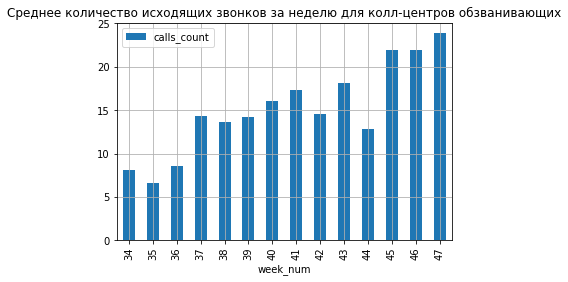

In [40]:
show_describe(data_calls_out.query('(direction in "out")'),'calls_count', 
              'Среднее количество исходящих звонков за неделю для колл-центров обзванивающих',list_out_calls)

count    558.000000
mean       6.568100
std        7.199505
min        1.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       59.000000
Name: calls_count, dtype: float64

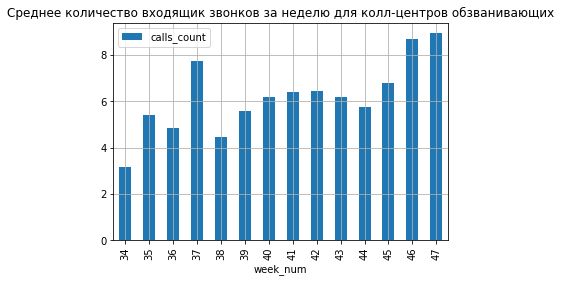

In [41]:
show_describe(data_calls_out.query('(direction in "in")'),'calls_count', 
              'Среднее количество входящик звонков за неделю для колл-центров обзванивающих',list_in_calls)

В колл-центры обзванивающие меньше поступает входящих звонков, чем исходящих, в 2 раза.

count    456.000000
mean       6.050439
std        8.406674
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       77.000000
Name: calls_count, dtype: float64

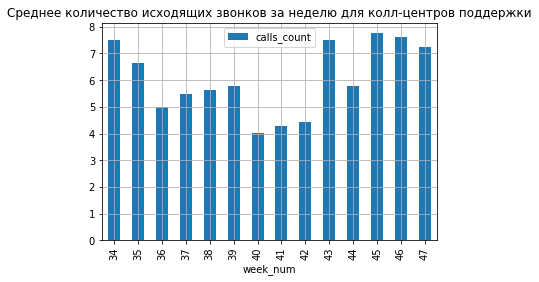

In [42]:
show_describe(data_calls_in.query('(direction in "out")'),'calls_count', 
              'Среднее количество исходящих звонков за неделю для колл-центров поддержки',list_out_calls)

count    928.000000
mean       8.910560
std       18.230147
min        1.000000
25%        2.000000
50%        5.000000
75%        9.000000
max      224.000000
Name: calls_count, dtype: float64

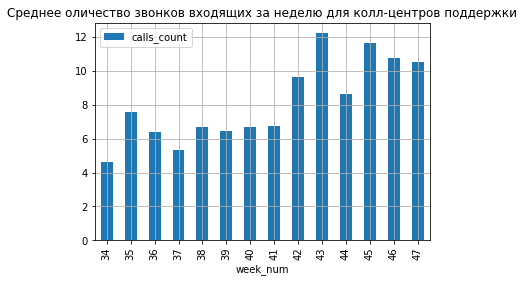

In [43]:
show_describe(data_calls_in.query('(direction in "in")'),'calls_count', 
              'Среднее оличество звонков входящих за неделю для колл-центров поддержки', list_in_calls)


В колл-центрах поддержки меньше исходящих звонков, чем входящих.

**Анализ длительности звонков**<a id='step_8'></a>

count      584.000000
mean      1097.352740
std       1592.216018
min         20.000000
25%        251.500000
50%        587.500000
75%       1211.250000
max      13532.000000
Name: call_duration, dtype: float64

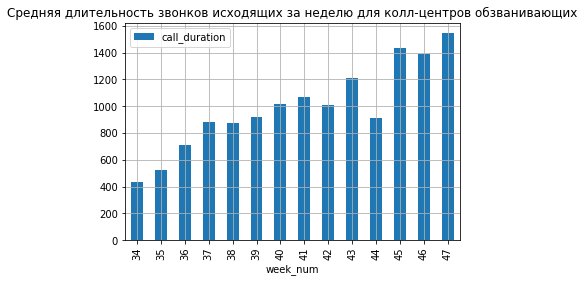

In [44]:
# данные для колл-центров обзванивающих о исходящих вызовах не пропущенных
show_describe(data_calls_out.query('(direction in "out") & (is_missed_call == False)'),'call_duration', 
              'Средняя длительность звонков исходящих за неделю для колл-центров обзванивающих', list_out_dur_calls)


Для колл-центров обзванивающих медианная длительность исходящих разговоров около 10 минут в неделю. Случаются более длинные звонки.

count      926.000000
mean       635.658747
std       1199.653992
min         20.000000
25%        136.000000
50%        394.000000
75%        743.750000
max      17452.000000
Name: call_duration, dtype: float64

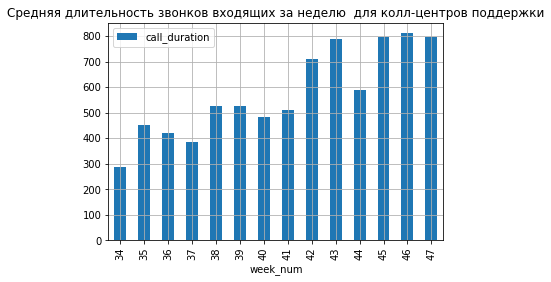

In [45]:
show_describe(data_calls_in.query('(direction in "in") & (is_missed_call == False)'),'call_duration', 
              'Средняя длительность звонков входящих за неделю  для колл-центров поддержки', list_in_dur_calls)


В колл-центры поддержки медианная длительность входящих звонков около 6 минут.

**Анализ длительности ожидания**<a id='step_9'></a>

count     584.000000
mean      158.563356
std       231.400182
min         4.000000
25%        36.000000
50%        85.000000
75%       171.000000
max      2084.000000
Name: expectation, dtype: float64

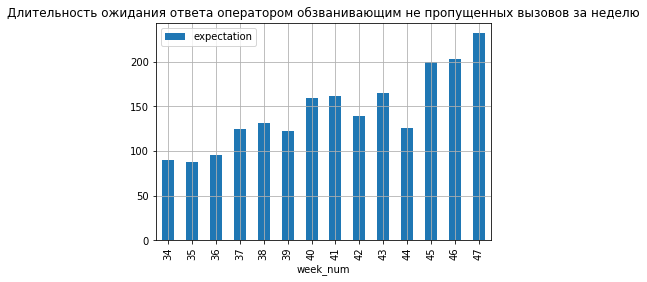

In [46]:
show_describe(data_calls_out.query('direction in "out" & (is_missed_call == False)'),'expectation', 
              'Длительность ожидания ответа оператором обзванивающим не пропущенных вызовов за неделю',list_out_exp_calls)

In [47]:
list_empty = []

count      6.00000
mean      46.50000
std       38.78015
min       11.00000
25%       18.25000
50%       33.00000
75%       68.00000
max      109.00000
Name: expectation, dtype: float64

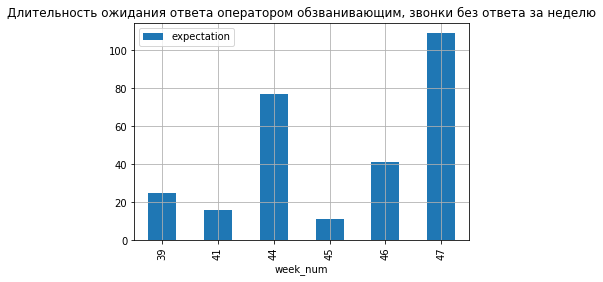

In [48]:
show_describe(data_calls_out.query('direction in "out" & (is_missed_call == True)'),'expectation', 
              'Длительность ожидания ответа оператором обзванивающим, звонки без ответа за неделю', list_empty)


Ожидание ответа абонента в обзванивающих колл-центрах 1,5 минуты. Не дожидаясь ответа, операторы кладут трубку примерно через пол минуты.

count     926.000000
mean      103.078834
std       172.418495
min         4.000000
25%        30.250000
50%        65.000000
75%       118.750000
max      2324.000000
Name: expectation, dtype: float64

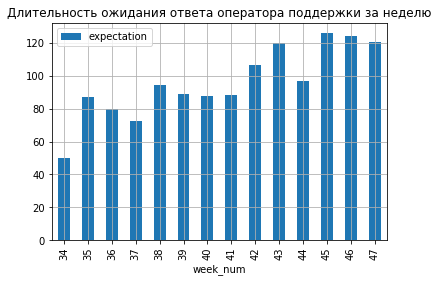

In [49]:
show_describe(data_calls_in.query('direction in "in" & (is_missed_call == False)'),'expectation', 
              'Длительность ожидания ответа оператора поддержки за неделю', list_out_exp_calls)

count     21.000000
mean      26.476190
std       27.619955
min        4.000000
25%       10.000000
50%       14.000000
75%       35.000000
max      105.000000
Name: expectation, dtype: float64

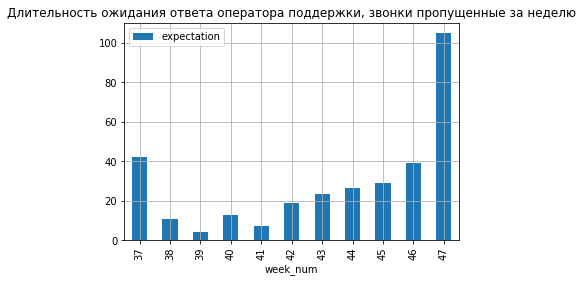

In [50]:
show_describe(data_calls_in.query('direction in "in" & (is_missed_call == True)'),'expectation', 
              'Длительность ожидания ответа оператора поддержки, звонки пропущенные за неделю', list_empty)

Операторы в среднем отвечают через 13 секунды. Не дождавшиеся ответа абоненты кладут трубку через 14 секунд. 

**Анализ пропущенных звонков**<a id='step_10'></a>

count    6.000000
mean     5.166667
std      3.060501
min      1.000000
25%      3.250000
50%      5.000000
75%      7.500000
max      9.000000
Name: calls_count, dtype: float64

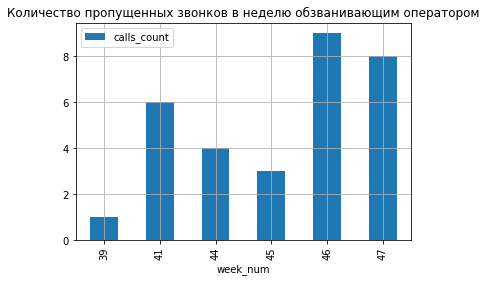

In [51]:
show_describe(data_calls_out.query('direction in "out" & (is_missed_call == True)'),'calls_count', 
              'Количество пропущенных звонков в неделю обзванивающим оператором', list_missed_calls)

Как минимум 5 звонков обзванивающего оператора остаются без ответа.

count    21.000000
mean      2.857143
std       3.978514
min       1.000000
25%       1.000000
50%       1.000000
75%       3.000000
max      18.000000
Name: calls_count, dtype: float64

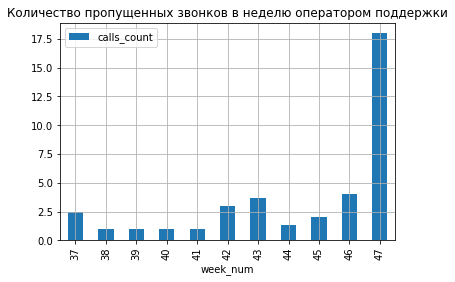

In [52]:
show_describe(data_calls_in.query('direction in "in" & (is_missed_call == True)'),'calls_count', 
              'Количество пропущенных звонков в неделю оператором поддержки', list_missed_calls)

Операторы поддержки, находясь на рабочем месте, редко пропускают больше одного звонка.

**Анализ звонков по дням недели**<a id='step_11'></a>

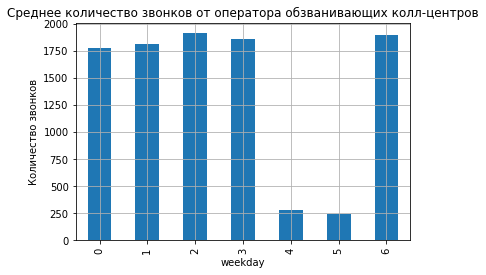

In [53]:
data_calls_out.query('direction in "out"').groupby(['weekday'])['calls_count'].sum().plot(kind = 'bar',grid = True)
plt.title('Среднее количество звонков от оператора обзванивающих колл-центров')
plt.ylabel('Количество звонков')
plt.show()

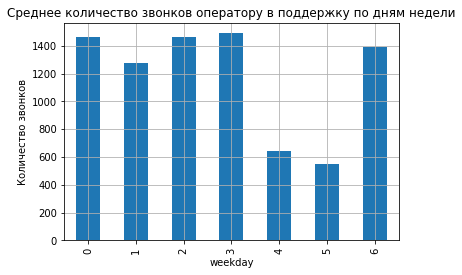

In [54]:
data_calls_in.query('direction in "in"').groupby('weekday')['calls_count'].sum().plot(kind = 'bar',grid = True)
plt.title('Среднее количество звонков оператору в поддержку по дням недели')
plt.ylabel('Количество звонков')
plt.show()

**Анализ внутренних и внешних вызовов**<a id='step_12'></a>

In [55]:
print('Количество внешних звонков обзванивающих колл центров в неделю', data_calls_out.query('internal == False').groupby(['week_num','user_id'])['calls_count'].sum().median())
print('Количество внутренних звонков обзванивающих колл центров в неделю', data_calls_out.query('internal == True').groupby(['week_num','user_id'])['calls_count'].sum().median())

Количество внешних звонков обзванивающих колл центров в неделю 9.0
Количество внутренних звонков обзванивающих колл центров в неделю 14.0


In [56]:
print('Количество внешних звонков обзванивающих колл центров в поддержки', data_calls_in.query('internal == False').groupby(['week_num','user_id'])['calls_count'].sum().median())
print('Количество внутренних звонков обзванивающих колл центров в поддержки', data_calls_in.query('internal == True').groupby(['week_num','user_id'])['calls_count'].sum().median())

Количество внешних звонков обзванивающих колл центров в поддержки 5.0
Количество внутренних звонков обзванивающих колл центров в поддержки 3.0


**Сводная таблица с медианными значениями значениями**<a id='step_13'></a>

In [57]:
list_out_dur_calls.append('-')
list_in_dur_calls.insert(0, '-')

In [58]:
table_median = pd.DataFrame({'type': ['output','input']})
table_median['calls_out'] = list_out_calls
table_median['calls_in']= list_in_calls 
table_median['duration_out'] = list_out_dur_calls
table_median['duration_in'] = list_in_dur_calls
table_median['expectation'] = list_out_exp_calls
table_median['missed'] = list_missed_calls
print('Таблица медианных значений для колл-центров разной направленности в неделю')
table_median

Таблица медианных значений для колл-центров разной направленности в неделю


,type,calls_out,calls_in,duration_out,duration_in,expectation,missed
0,output,8.0,4.0,587.5,-,85.0,5.0
1,input,4.0,5.0,-,394,65.0,1.0


**Выводы по исследовательскому анализу данных:**
    
    обзванивающие коллцентры:
        - исходящих вызовов в 2 раза больше, чем входящих;
        - для колл-центров обзванивающих медианная длительность исходящего звонка 1.2 минуты;
        - ожидание ответа абонента оператором около 10 секунд;
        - около 5 вызовов в неделю остаются без ответа;
        - не дожидаются ответа абонентом через почти 1,5 минуты;
        - в субботу и пятницу нагрузка на колл-центры в ниже;
    колл-центры поддержки:    
        - исходящих звонков немного меньше, чем входящих;
        - медианная длительность входящего звонка 1.5 минуты;
        - отвечают через 13 секунды;
        - абоненты кладут трубку через 14 секунд;
        - в субботу и пятницу меньше всего звонков в колл-центры.




Проанализировала данные по неделям и вычислила средние значения по ним, так как по дням значения достаточно маленькие и выше погрешность вычислений. Тем более в какие то дни операторы могут выходить не все или ещё какие то обстоятельства. Группировала данные по клиентам.
    


### Создание портрета неэффективного оператора


Определим критерии эффективности операторов по неделям.    



**Для колл-центров обзванивающих**<a id='step_14'></a>

In [59]:
# выделение необходимых данных
operators_out_df = data_calls_out.query('direction in "out"').\
                                    groupby(['operator_id', 'week_num','is_missed_call'])[['calls_count', 'call_duration']].sum().reset_index()
operators_out_df

,operator_id,week_num,is_missed_call,calls_count,call_duration
0,880022.0,35,False,1,239
1,880022.0,36,False,7,594
2,880022.0,37,False,5,479
3,880022.0,38,False,5,710
4,880022.0,39,False,3,353
...,...,...,...,...,...
1471,963716.0,46,False,1,25
1472,964510.0,47,False,7,551
1473,964716.0,47,False,3,511
1474,965328.0,47,False,8,442


In [60]:
# Подсчёт средней длительности разговора оператора
operators_out_df['mean_duration'] = operators_out_df['call_duration']/operators_out_df['calls_count']

In [61]:
operators_out_df.query('is_missed_call == False')['mean_duration'].describe()

count    1469.000000
mean       80.286699
std        64.157445
min         6.500000
25%        40.666667
50%        64.500000
75%        97.750000
max       517.000000
Name: mean_duration, dtype: float64

In [62]:
# анализ Количество звонков в неделю
operators_out_df.groupby(['operator_id','week_num'])['calls_count'].sum().describe()

count    1469.000000
mean        6.658271
std         6.482236
min         1.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        50.000000
Name: calls_count, dtype: float64

Для операторов, работающих в обзванивающих колл-центрах, важно количество совершённых звонков и длительность - насколько они смогли заинтересовать абонента своим предложением.

У половины операторов получается совершать звонки длительностью больше минуты. Будем считать, что плохой оператор совершает звонки со средней длительностью меньше 98 секунд (3 квартиль). Для качественной работы оператора и звонков исходящих должно быть достаточно, больше 9 в неделю(3 квартиль).

In [63]:
# критерии плохого оператора на исходящие вызовыб выбрана медиана, можно выбрать из функции describe любую другую перцентиль
calls_count_median_out = operators_out_df.groupby(['operator_id','week_num'])['calls_count'].sum().describe()[6]
calls_duration_median_out = operators_out_df.query('is_missed_call == False')['mean_duration'].describe()[6]

In [64]:
# таблица соотвествия оператора клиенту
data_calls_out_user_oper = data_calls_out.groupby('operator_id',as_index=False).agg({'user_id': pd.Series.unique})

In [65]:
def bad_operator_output(df):
    '''функция определения плохих операторов для исходящих звонков'''
    bad_operator_list = []
    count_cut = df.groupby(['operator_id','week_num'])['calls_count'].sum().reset_index()
    count_cut = count_cut.query('calls_count < @calls_count_median_out')
    count_cut_merged = count_cut.merge(df.query('is_missed_call == False')[['operator_id','week_num','mean_duration']],\
                                       left_on=['operator_id','week_num'], right_on=['operator_id','week_num'],how='left')
    for oper in count_cut['operator_id'].unique():
        if count_cut_merged.loc[((count_cut_merged['operator_id'] == oper)),\
                                'mean_duration'].min() < calls_duration_median_out:
            bad_operator_list.append(oper)
    bad_operators_out_df = pd.DataFrame({'operator_id':bad_operator_list})         
    bad_operators_out_df = bad_operators_out_df.merge(data_calls_out_user_oper, on = 'operator_id', how = 'left')     
    return bad_operators_out_df
    

In [66]:
print('Список операторов, не проходящих требования по количеству звонков и их средней длительности')
bad_operator_output(operators_out_df)

Список операторов, не проходящих требования по количеству звонков и их средней длительности


,operator_id,user_id
0,880022.0,166377
1,880026.0,166377
2,880028.0,166377
3,882684.0,166405
4,882686.0,166405
...,...,...
301,960950.0,166407
302,963716.0,167078
303,964510.0,167545
304,965328.0,166688


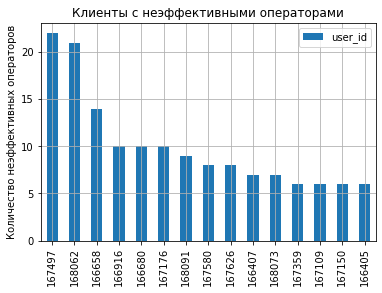

In [67]:
labels = bad_operator_output(operators_out_df)['user_id'].value_counts().head(15).to_frame().index.to_list()
fig = (bad_operator_output(operators_out_df)['user_id'].value_counts().head(15)).plot(kind = 'bar', grid = True, legend = True)
plt.title('Клиенты с неэффективными операторами')
plt.ylabel('Количество неэффективных операторов')
plt.show()

In [68]:
users_with_bad_operators = bad_operator_output(operators_out_df)['user_id'].unique()
bad_operators = bad_operator_output(operators_out_df)['operator_id'].unique()

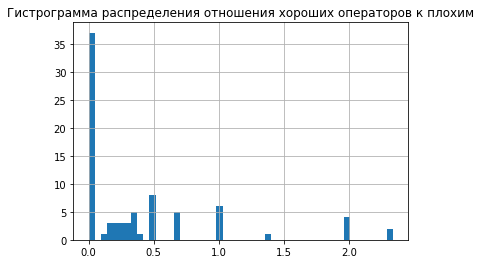

In [69]:
count_bad_operators = 0
count_good_operators = 0
bad_list = []
good_list = []
for user in users_with_bad_operators:
    all_opers = len(data_calls_out_user_oper.query('(user_id == @user)')['operator_id'].tolist())
    bad_list.append(len(data_calls_out_user_oper.query('(user_id == @user) & (operator_id in @bad_operators)')['operator_id'].tolist()))
    good_list.append(len(data_calls_out_user_oper.query('(user_id == @user) & (operator_id not in @bad_operators)')['operator_id'].tolist()))
df_bad = pd.DataFrame({'user_id':users_with_bad_operators, 'bad':bad_list, 'good':good_list})
df_bad['good_to_bad']= df_bad['good']/df_bad['bad']

df_bad['good_to_bad'].hist(bins = 50)
plt.title('Гистрограмма распределения отношения хороших операторов к плохим')
plt.show()

В колл-центрах с неэффективными операторами проанализировали соотношение "плохих" и "хороших" операторов. Выявили, что во многих колл-центрах неэффективных операторов больше, чем эффективных. На это следует обратить внимание.

**Для колл-центров поддержки**<a id='step_15'></a>

In [70]:
operators_in_df = data_calls_in.query('direction in "in"').\
                                groupby(['operator_id', 'week_num','is_missed_call'])[['calls_count', 'expectation']].sum().reset_index()
# Средняя длительность ожидания ответа оператора
operators_in_df['mean_expectation'] = operators_in_df['expectation']/operators_in_df['calls_count']


In [71]:
operators_in_df.query('is_missed_call == False')['mean_expectation'].describe()

count    1584.000000
mean       15.235485
std        10.170579
min         0.571429
25%         8.375000
50%        13.000000
75%        19.000000
max        80.000000
Name: mean_expectation, dtype: float64

In [72]:
operators_in_df.query('is_missed_call == True').groupby(['operator_id','week_num'])['calls_count'].sum().describe()

count    32.000000
mean      1.875000
std       1.338029
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       6.000000
Name: calls_count, dtype: float64

Для операторов, работающих в колл-центрах поддержки, важно количество пропущенных звонков и длительность ожидания ответа - насколько они быстро смогли ответить абоненту.

У половины операторов получается пропускать всего один звонок в день. Будем считать, что плохой оператор пропускает больше 1 звонка в неделю (1 квартиль). Для качественной работы оператора время ожидания должно быть как можно меньше, меньше 8 секунд(1 квартиль).

In [73]:
# критерии плохого оператора на входящие вызовы, выбрана медиана, можно выбрать из функции describe любую другую квантиль
calls_expectation_median_in = operators_in_df.query('is_missed_call == False')['mean_expectation'].describe()[3]
calls_missed_median_in = operators_in_df.query('is_missed_call == True').groupby(['operator_id','week_num'])['calls_count'].sum().describe()[3]

In [74]:
# таблица соотвествия оператора клиенту
data_calls_in_user_oper = data_calls_in.groupby('operator_id',as_index=False).agg({'user_id': pd.Series.unique})

In [75]:

def bad_operator_input(df):
    '''функция определения плохих операторов для входящих звонков'''
    bad_operator_list = []
    count_cut = df.query(' (is_missed_call == True)').groupby(['operator_id','week_num'])['calls_count'].sum().reset_index()
    count_cut = count_cut.query('calls_count > @calls_missed_median_in')
    count_cut_merged = count_cut.merge(df.query('is_missed_call == False')\
                                       [['operator_id','week_num','mean_expectation']], left_on=['operator_id','week_num'], right_on=['operator_id','week_num'],how='left')
    for oper in count_cut['operator_id'].unique():
        if count_cut_merged.loc[((count_cut_merged['operator_id'] == oper)),\
                                'mean_expectation'].max() > calls_expectation_median_in:
            bad_operator_list.append(oper)
    bad_operators_in_df = pd.DataFrame({'operator_id':bad_operator_list})         
    bad_operators_in_df = bad_operators_in_df.merge(data_calls_in_user_oper, on = 'operator_id', how = 'left')  
    return bad_operators_in_df

In [76]:
 print('Список операторов, не проходящих требования по количеству пропущенных звонков и их среднего ожидания ответа')      
bad_operator_input(operators_in_df)


Список операторов, не проходящих требования по количеству пропущенных звонков и их среднего ожидания ответа


,operator_id,user_id
0,908960.0,166541
1,920706.0,167445
2,940588.0,168252
3,940614.0,168252
4,940622.0,168252
5,940624.0,168252
6,940630.0,168252
7,940652.0,168252
8,964666.0,168252


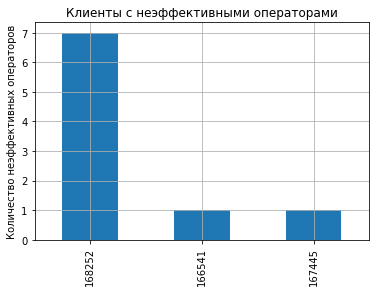

In [77]:
labels = bad_operator_input(operators_in_df)['user_id'].value_counts().to_frame().index.to_list()
fig = bad_operator_input(operators_in_df)['user_id'].value_counts().plot(kind = 'bar',grid = True)
plt.title('Клиенты с неэффективными операторами')
plt.ylabel('Количество неэффективных операторов')
plt.show()

In [78]:
users_with_bad_operators_in = bad_operator_input(operators_in_df)['user_id'].unique()
bad_operators_in = bad_operator_input(operators_in_df)['operator_id'].unique()

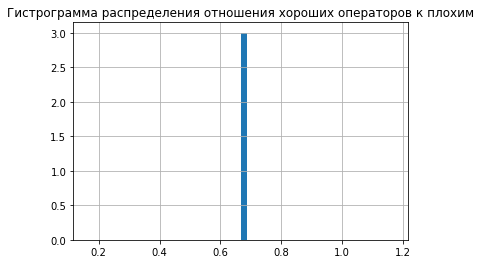

In [79]:
count_bad_operators = 0
count_good_operators = 0
bad_list = []
good_list = []
for user in users_with_bad_operators_in:
    all_opers = len(data_calls_in_user_oper.query('(user_id == @user)')['operator_id'].tolist())
    bad_list.append(len(data_calls_in_user_oper.query('(user_id == @user) & (operator_id in @bad_operators_in)')['operator_id'].tolist()))
    good_list.append(len(data_calls_in_user_oper.query('(user_id == @user) & (operator_id not in @bad_operators_in)')['operator_id'].tolist()))
df_bad_in = pd.DataFrame({'user_id':users_with_bad_operators_in, 'bad':bad_list, 'good':good_list})
df_bad_in['good_to_bad']= df_bad['good']/df_bad['bad']

df_bad_in['good_to_bad'].hist(bins = 50)
plt.title('Гистрограмма распределения отношения хороших операторов к плохим')
plt.show()

В колл-центрах поддержки соотношение "плохих" и "хороших" операторов не очень хорошее. Неэффективных операторов больше. 

**Клиенты с пропущенными вызовами**<a id='step_16'></a>

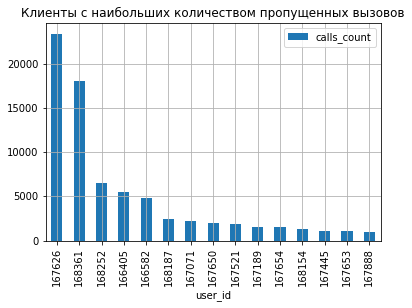

In [80]:
labels = data_calls_without_op_id.groupby('user_id')['calls_count'].sum().reset_index().sort_values(by = 'calls_count', ascending=False).head(15)['user_id'].to_list()
data_calls_without_op_id.groupby('user_id')['calls_count'].sum().reset_index().sort_values(by = 'calls_count', ascending=False).head(15).plot(kind='bar',x = 'user_id', y = 'calls_count',legend=True, grid = True)
plt.title('Клиенты с наибольших количеством пропущенных вызовов')
plt.show()

In [81]:
print('Процент колл-центров с неэффективными операторами = ', ((len(users_with_bad_operators_in) + len(users_with_bad_operators))/ data['user_id'].unique().shape[0])* 100)

Процент колл-центров с неэффективными операторами =  31.716417910447763


In [82]:
print('Топ-15 колл-центров с пропущенными вызовами')
display(data_calls_without_op_id.groupby('user_id')['calls_count'].\
        sum().reset_index().sort_values(by = 'calls_count', ascending=False).head(15))

Топ-15 колл-центров с пропущенными вызовами


,user_id,calls_count
175,167626,23382
283,168361,17997
270,168252,6498
4,166405,5520
22,166582,4829
263,168187,2407
98,167071,2256
182,167650,2033
163,167521,1863
126,167189,1549


### Проверка гипотез

**Нулевая гипотеза: статистически значимых отличий в ожидании ответа на различных тарифах нет**<a id='step_17'></a>

In [83]:
# подготовка данных к проверке гипотез
data['mean_expectation'] = data['expectation'] / data['calls_count']
data_hipot = data.query('direction == "in"')
data_hipot.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,weekday,month,week_num,expectation,tariff_plan,date_start,mean_expectation
63,166377,2019-08-21,in,False,880020.0,False,1,33,49,2,8,34,16,B,2019-08-01,16.0
64,166377,2019-08-22,in,False,880026.0,False,1,45,52,3,8,34,7,B,2019-08-01,7.0
66,166377,2019-08-22,in,False,880028.0,False,1,41,54,3,8,34,13,B,2019-08-01,13.0
71,166377,2019-08-25,in,False,880028.0,False,2,285,302,6,8,34,17,B,2019-08-01,8.5
86,166377,2019-08-28,in,False,880026.0,False,1,48,52,2,8,35,4,B,2019-08-01,4.0


In [84]:
# разбиение по тарифам
calls_A = data_hipot[data_hipot['tariff_plan'] == 'A']['mean_expectation']
calls_B = data_hipot[data_hipot['tariff_plan'] == 'B']['mean_expectation']
calls_C = data_hipot[data_hipot['tariff_plan'] == 'C']['mean_expectation']

Примененим Дисперсионный анализ (ANOVA), так как у нас три независимых образца. 

In [85]:
p_value = stats.f_oneway(calls_A, calls_B, calls_C)[1]
print(p_value)
if p_value < 0.05:
    print('Отвергаем нулевую гипотезу, статистически значимые различия между ожиданием на различных тарифах есть')
else:
    print('Не отвергаем нулевую гипотезу о том, что статистически значимых различий в ожидании на различных тарифах нет')
print('Средние значения:','\n',"A -", calls_A.mean(),'\n',"B -", calls_B.mean(),'\n',"C -", calls_C.mean())          


0.010034676414012858
Отвергаем нулевую гипотезу, статистически значимые различия между ожиданием на различных тарифах есть
Средние значения: 
 A - 14.920091645473615 
 B - 15.923138478973232 
 C - 15.988900409714256


**Нулевая гипотеза: статистически значимых отличий в длительности звонков внутренних и внешних нет**<a id='step_18'></a>

In [86]:
# подготовка дщанных к проверке гипотез
data['mean_duration'] = data['call_duration'] / data['calls_count']

In [87]:
calls_in = data[data['internal'] == True]['mean_duration']
calls_out = data[data['internal'] == False]['mean_duration']


Воспользуемся непараметрической статистической проверкой гипотез Манна-Уитни. Проверим, равны ли распределения двух независимых выборок или нет.

In [88]:
p_value_2 = stats.mannwhitneyu(calls_in, calls_out)[1]
print(p_value_2)
if p_value_2 < 0.05:
    print('Отвергаем нулевую гипотезу, статистически значимые различия между длительностями внутренних и внешних звонков есть')
else:
    print('Не отвергаем нулевую гипотезу о том, что статистически значимых различий между длительностями внутренних и внешних звонков нет')
          
print('Средние значения:','\n',"Внутренние -", calls_in.mean(),'\n',"Внешние -", calls_out.mean())   

1.6984149507050672e-88
Отвергаем нулевую гипотезу, статистически значимые различия между длительностями внутренних и внешних звонков есть
Средние значения: 
 Внутренние - 61.14151498746446 
 Внешние - 91.9377357626941


### Выводы и рекомендации

**В ходе работы были проделаны следующие этапы:**<a id='step_19'></a>

    - проанализировали данные;
    - подготовили их к дальнейшим исследованиям, а именно: удалили дубликаты, преобразовали к нужным типам, обработали пропуски, провели дополнительные расчёты;
    - почистили данные от выбросов;
    - определили колл-центры, работающие на обзвонить клиентов и на входящие звонки;
    - исследовали среднее количество входящих и исходящих звонков для различного типа колл-центров;
    - проанализировали длительности звонков  и ожидания по типам;
    - определили среднее количество пропущенных оператором вызовов;
    - проанализировали количество звонков по дням недели;
    - написали функцию для определения неэффективных операторов для различных колл-центров;
    - проверили зависит ли ожидание ответа оператора от тарифа;
    - проверили зависит ли длительность звонков от того внутренние они или внешние.

**Рекомендации:**

    - сообщить колл-центрам с большим количеством пропущенных вызовов об этом, возможно есть какая-то ошибка при передаче данных;
    - сообщить о дубликатах в данных;
    - в колл-центрах поддержки больше внутренних звонков, возможно, можно сменить тарифы в соответствии с этим;
    - колл-центрам с большим количеством неэффективных сотрудников предложить обучение операторов;
    - организовывать для клиентов вебинары, на которых рассказывать как улучшить эффективность и предлагать продукты и тарифы, которые этому способствуют;
    - проанализировать количество операторов клиентов и нагрузку по дням недели;
    - предложить услугу "Тайный звонящий";
    Для клиентов:
        - для обзванивающих колл-центров предложить регламентировать время ожидания ответа абонентом;
        - на основании анализа данных определить KPI для операторов;
        - создание системы обратной связи от абонента;
        - определить постоянных клиентов и направвлять их на более опытных операторов.
    

In [89]:
#data.to_csv('data_dash.csv', index=False)

In [90]:
#data_calls_without_op_id.to_csv('data_missed.csv', index=False)